In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=3fd9995ee46411d08630ca99622ffdd1aedecd7cd46bb4addd01c5356f680ea6
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
!pip uninstall torch torchvision torchaudio -y
!pip cache purge  # Clear cache
!pip install torch torchvision torchaudio


Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Files removed: 65
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 747.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 96.8 MB/s eta 0:00:00


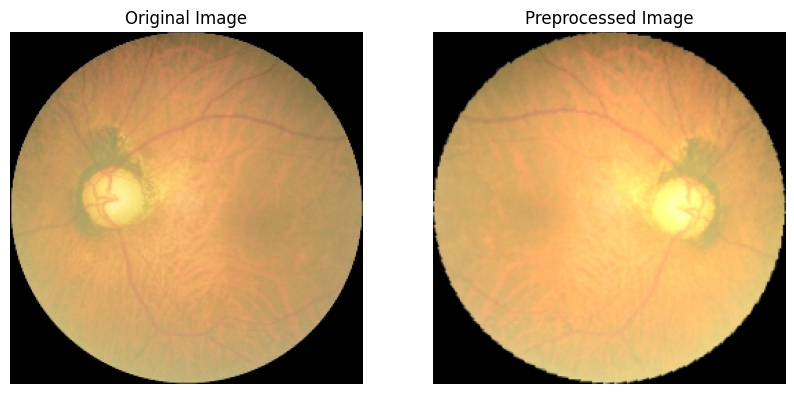

✅ Dataset Mean: [-0.56350213 -1.0077032  -1.1346318 ]
✅ Dataset Std Deviation: [1.1773684 0.8398744 0.673832 ]


In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 🔹 **Dataset Path**
data_dir = "/content/drive/MyDrive/dataset"  # Update path as needed

# 🔹 **Define Preprocessing Pipeline**
transform = transforms.Compose([
    transforms.Resize((224, 224)),         # Resize images to match model input size
    transforms.RandomHorizontalFlip(),     # Augmentation: Random flip
    transforms.RandomRotation(10),         # Augmentation: Random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Augmentation: Brightness & contrast change
    transforms.ToTensor(),                 # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# 🔹 **Load Dataset**
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# 🔹 **Display Original vs Preprocessed Image**
def show_images_before_after(image_path):
    # Load original image
    original_image = Image.open(image_path).convert("RGB")

    # Apply preprocessing
    preprocessed_image = transform(original_image)

    # Convert tensors for visualization
    preprocessed_image = preprocessed_image.permute(1, 2, 0).numpy()  # Convert (C, H, W) → (H, W, C)
    preprocessed_image = (preprocessed_image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # De-normalize

    # Plot images
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original_image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(np.clip(preprocessed_image, 0, 1))  # Ensure valid range
    ax[1].set_title("Preprocessed Image")
    ax[1].axis("off")

    plt.show()

# 🔹 **Calculate Mean & Standard Deviation**
def compute_dataset_statistics(data_loader):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_images = 0

    for images, _ in data_loader:
        batch_size, _, _, _ = images.shape
        images = images.view(batch_size, 3, -1)  # Flatten each image (C, H*W)

        mean += images.mean(dim=[0, 2])  # Compute mean across batches
        std += images.std(dim=[0, 2])  # Compute std across batches
        total_images += batch_size

    mean /= len(data_loader)
    std /= len(data_loader)

    return mean.numpy(), std.numpy()

# 🔹 **Example Usage**
test_image_path = "/content/drive/MyDrive/dataset/Glaucoma/EyePACS-Glaucoma-5.jpg"  # Change this path
show_images_before_after(test_image_path)

# Compute dataset statistics
mean, std = compute_dataset_statistics(data_loader)
print(f"✅ Dataset Mean: {mean}")
print(f"✅ Dataset Std Deviation: {std}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.models import efficientnet_b0
from transformers import ViTModel, ViTConfig
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 🚀 Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ **Dataset Path (Google Drive)**
data_dir = "/content/drive/MyDrive/dataset"  # Change if needed

# 🔹 **Preprocessing Pipeline**
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])s

# 🔹 **Load Dataset with Correct Class Labels**
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# ✅ **Ensuring Correct Label Order**
# Class 0 -> Glaucoma | Class 1 -> Normal
assert dataset.classes[0] == "Glaucoma", "First class should be 'Glaucoma'"
assert dataset.classes[1] == "Normal", "Second class should be 'Normal'"

print("✅ Class Mapping:", dataset.class_to_idx)  # Should print: {'Glaucoma': 0, 'Normal': 1}

# 🔹 **Train-Test Split (80%-20%)**
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 🔹 **Hybrid Model (EfficientNet + ViT)**
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()

        # Load Pretrained EfficientNet
        self.efficientnet = efficientnet_b0(weights="IMAGENET1K_V1")
        self.efficientnet.classifier = nn.Identity()  # Remove last FC layer

        # Load Vision Transformer (ViT)
        self.vit_config = ViTConfig(image_size=224, num_labels=2)
        self.vit = ViTModel(self.vit_config)

        # Fully Connected Layer
        self.fc = nn.Sequential(
            nn.Linear(1280 + self.vit_config.hidden_size, 512),
            nn.Mish(),  # Activation
            nn.Dropout(0.3),
            nn.Linear(512, 2)  # Two classes: Glaucoma (0) and Normal (1)
        )

    def forward(self, x):
        eff_features = self.efficientnet(x)
        vit_features = self.vit(x).last_hidden_state[:, 0, :]
        features = torch.cat((eff_features, vit_features), dim=1)
        return self.fc(features)

# 🚀 Load Model to GPU
model = HybridModel().to(device)

# 🔹 **Loss, Optimizer, and Scheduler**
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# 🔹 **Training Function**
def train_model(model, train_loader, criterion, optimizer, scheduler, epochs=12):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()

        scheduler.step()
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total  # Convert to percentage

        print(f"📌 Epoch {epoch+1} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")

# 🔥 **Train Model**
train_model(model, train_loader, criterion, optimizer, scheduler)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


✅ Class Mapping: {'Glaucoma': 0, 'Normal': 1}


100%|██████████| 20.5M/20.5M [00:00<00:00, 78.9MB/s]


📌 Epoch 1 | Loss: 0.5748 | Accuracy: 68.20%
📌 Epoch 2 | Loss: 0.3893 | Accuracy: 81.70%
📌 Epoch 3 | Loss: 0.3157 | Accuracy: 85.76%
📌 Epoch 4 | Loss: 0.2623 | Accuracy: 89.34%
📌 Epoch 5 | Loss: 0.2012 | Accuracy: 91.96%
📌 Epoch 6 | Loss: 0.1936 | Accuracy: 92.76%
📌 Epoch 7 | Loss: 0.1560 | Accuracy: 93.65%
📌 Epoch 8 | Loss: 0.1524 | Accuracy: 94.64%
📌 Epoch 9 | Loss: 0.1313 | Accuracy: 95.24%
📌 Epoch 10 | Loss: 0.1241 | Accuracy: 95.29%
📌 Epoch 11 | Loss: 0.1393 | Accuracy: 94.49%
📌 Epoch 12 | Loss: 0.1276 | Accuracy: 94.99%


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/glaucoma_hybrid_model.pth")


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.models import efficientnet_b0
from transformers import ViTModel, ViTConfig

# 🚀 Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ **Load Trained Model**
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()

        # Load Pretrained EfficientNet
        self.efficientnet = efficientnet_b0(weights="IMAGENET1K_V1")
        self.efficientnet.classifier = nn.Identity()

        # Load Vision Transformer (ViT)
        self.vit_config = ViTConfig(image_size=224, num_labels=2)
        self.vit = ViTModel(self.vit_config)

        # Fully Connected Layer
        self.fc = nn.Sequential(
            nn.Linear(1280 + self.vit_config.hidden_size, 512),
            nn.Mish(),
            nn.Dropout(0.3),
            nn.Linear(512, 2)  # Two classes: Glaucoma (0) and Normal (1)
        )

    def forward(self, x):
        eff_features = self.efficientnet(x)
        vit_features = self.vit(x).last_hidden_state[:, 0, :]
        features = torch.cat((eff_features, vit_features), dim=1)
        return self.fc(features)

# Load Model
model = HybridModel().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/glaucoma_hybrid_model.pth"))
model.eval()  # Set to evaluation mode

# 🔹 **Data Preprocessing (Same as Training)**
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Test Dataset
data_dir = "/content/drive/MyDrive/dataset"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split Dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
_, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 🔹 **Testing Function**
def test_model(model, test_loader):
    correct = 0
    total = 0
    class_names = ["Glaucoma", "Normal"]

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"✅ Model Accuracy on Test Data: {accuracy:.2f}%")

# 🔥 **Run Testing**
test_model(model, test_loader)


✅ Model Accuracy on Test Data: 97.42%


In [ ]:
!pip install lime

  0%|          | 0/1000 [00:00<?, ?it/s]

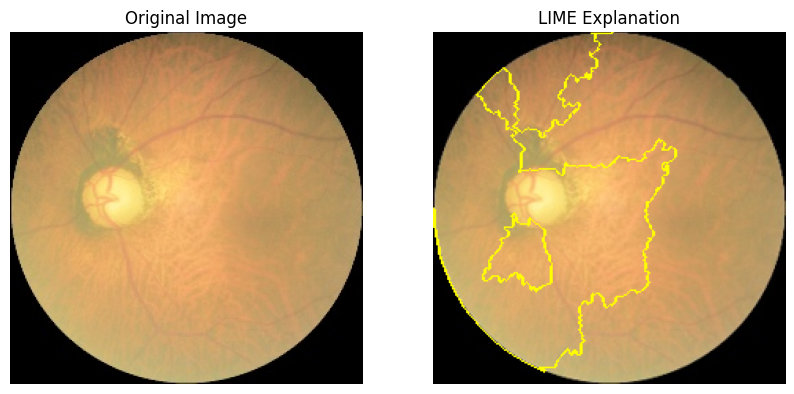

In [ ]:
import torch
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image
from torchvision.models import efficientnet_b0
from transformers import ViTModel, ViTConfig

# 🚀 Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ **Load Trained Model**
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()

        # Load Pretrained EfficientNet
        self.efficientnet = efficientnet_b0(weights="IMAGENET1K_V1")
        self.efficientnet.classifier = nn.Identity()

        # Load Vision Transformer (ViT)
        self.vit_config = ViTConfig(image_size=224, num_labels=2)
        self.vit = ViTModel(self.vit_config)

        # Fully Connected Layer
        self.fc = nn.Sequential(
            nn.Linear(1280 + self.vit_config.hidden_size, 512),
            nn.Mish(),
            nn.Dropout(0.3),
            nn.Linear(512, 2)  # Two classes: Glaucoma (0) and Normal (1)
        )

    def forward(self, x):
        eff_features = self.efficientnet(x)
        vit_features = self.vit(x).last_hidden_state[:, 0, :]
        features = torch.cat((eff_features, vit_features), dim=1)
        return self.fc(features)

# Load Model
model = HybridModel().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/glaucoma_hybrid_model.pth"))
model.eval()  # Set to evaluation mode

# 🔹 **Data Preprocessing**
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load an Example Image for LIME
image_path = "/content/drive/MyDrive/dataset/Glaucoma/EyePACS-Glaucoma-5.jpg"
original_image = Image.open(image_path).convert("RGB")

# Transform Image
transformed_image = transform(original_image).unsqueeze(0).to(device)  # Add batch dimension

# 🔹 **Define LIME Explainer**
explainer = lime_image.LimeImageExplainer()

# 🔹 **Define Prediction Function for LIME**
def predict(images):
    images_resized = []

    for img in images:
        img_pil = Image.fromarray(img)  # Convert NumPy array to PIL
        img_resized = img_pil.resize((224, 224))  # Resize to 224x224
        img_tensor = transform(img_resized).unsqueeze(0)  # Apply same preprocessing
        images_resized.append(img_tensor)

    images_tensor = torch.cat(images_resized, dim=0).to(device)

    outputs = model(images_tensor)
    return torch.nn.functional.softmax(outputs, dim=1).cpu().detach().numpy()



# 🔥 **Run LIME Explanation**
explanation = explainer.explain_instance(
    np.array(original_image.resize((224, 224))),  # Resize before passing
    predict,
    top_labels=2,
    hide_color=0,
    num_samples=1000
)


# 🔹 **Display LIME Heatmap**
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],  # Class with highest probability
    positive_only=True,
    num_features=10,
    hide_rest=False
)

# 🔹 **Plot Results**
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original Image
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

# LIME Explanation
axes[1].imshow(mark_boundaries(temp, mask))
axes[1].set_title("LIME Explanation")
axes[1].axis("off")

plt.show()


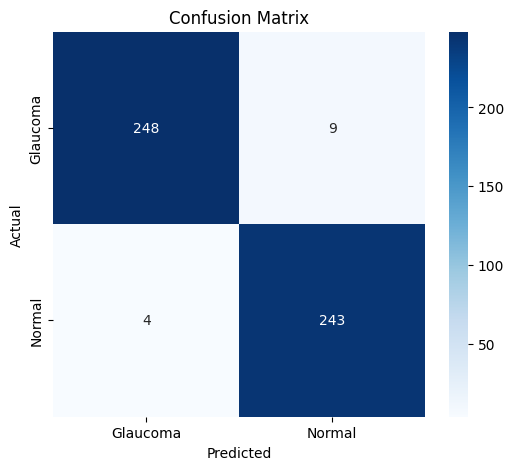

🔹 Classification Report:
              precision    recall  f1-score   support

    Glaucoma       0.98      0.96      0.97       257
      Normal       0.96      0.98      0.97       247

    accuracy                           0.97       504
   macro avg       0.97      0.97      0.97       504
weighted avg       0.97      0.97      0.97       504



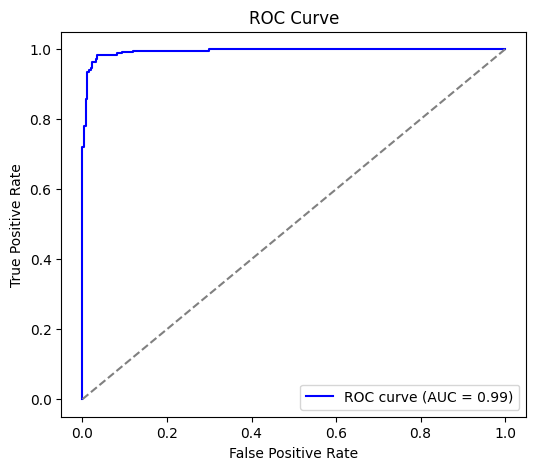

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

# 🔹 **Evaluate Model**
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Store true labels & predictions
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            # Store Softmax probabilities for ROC curve
            softmax_probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Probability of class 1 (Normal)
            y_scores.extend(softmax_probs.cpu().numpy())

    return y_true, y_pred, y_scores

# Get predictions
y_true, y_pred, y_scores = evaluate_model(model, test_loader)

# 🔹 **Confusion Matrix**
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Glaucoma', 'Normal'], yticklabels=['Glaucoma', 'Normal'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 🔹 **Classification Report**
print("🔹 Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Glaucoma', 'Normal']))

# 🔹 **ROC Curve**
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random model line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


🔹 Model Prediction: Glaucoma (Confidence: 99.94%)


  0%|          | 0/1000 [00:00<?, ?it/s]

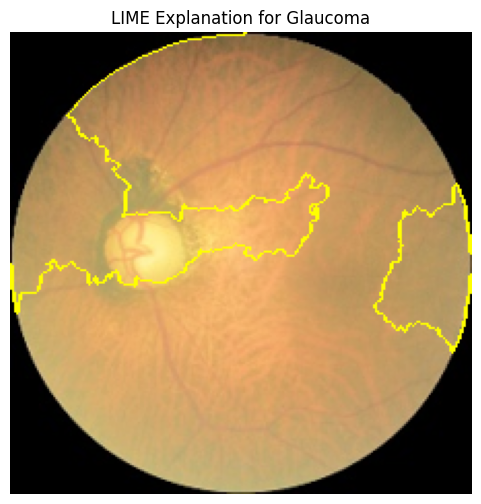

In [ ]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# 🔹 **Load & Preprocess Image**
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return transform(image).unsqueeze(0)  # Add batch dimension

# 🔹 **Prediction Function for LIME**
def predict_fn(images):
    images = np.array(images)  # Convert to NumPy array
    images = (images * 255).astype(np.uint8)  # Convert to uint8 (0-255 range)

    # Convert images to tensors
    images_tensor = torch.stack([
        transforms.ToTensor()(Image.fromarray(img)) for img in images
    ])

    # Normalize the tensors (as required by the model)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    images_tensor = torch.stack([normalize(img) for img in images_tensor])

    # Move to GPU if available
    images_tensor = images_tensor.to(device)

    # Get model predictions
    outputs = model(images_tensor)
    probs = torch.nn.functional.softmax(outputs, dim=1).cpu().detach().numpy()
    return probs

# 🔹 **LIME Explanation Function**
def lime_explanation(image_path, model):
    model.eval()

    # Load and preprocess image
    image_tensor = preprocess_image(image_path).to(device)

    # Get Model Prediction
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1).cpu().numpy()[0]
        predicted_class = np.argmax(probabilities)

    # Class Labels
    class_labels = ["Glaucoma", "Normal"]
    predicted_label = class_labels[predicted_class]

    print(f"🔹 Model Prediction: {predicted_label} (Confidence: {probabilities[predicted_class]*100:.2f}%)")

    # Load raw image (un-normalized) for LIME
    image = Image.open(image_path).convert("RGB")
    image = np.array(image.resize((224, 224)))  # Resize image to match model input size

    # Initialize LIME explainer
    explainer = lime_image.LimeImageExplainer()

    # Run LIME on the image
    explanation = explainer.explain_instance(
        image,
        predict_fn,
        top_labels=2,
        hide_color=0,
        num_samples=1000
    )

    # Get superpixel mask for the most important features
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    # 🔹 **Visualize Explanation**
    plt.figure(figsize=(6, 6))
    plt.imshow(mark_boundaries(temp, mask))
    plt.axis('off')
    plt.title(f"LIME Explanation for {predicted_label}")
    plt.show()

# 🔹 **Run LIME Explanation with Prediction**
test_image_path = "/content/drive/MyDrive/dataset/Glaucoma/EyePACS-Glaucoma-5.jpg"  # Change this path
lime_explanation(test_image_path, model)


🔹 Model Prediction: Normal (Confidence: 88.20%)


  0%|          | 0/1000 [00:00<?, ?it/s]

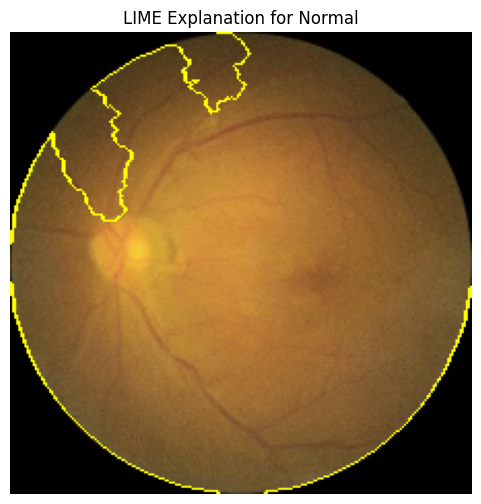

In [ ]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# 🔹 **Load & Preprocess Image**
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return transform(image).unsqueeze(0)  # Add batch dimension

# 🔹 **Prediction Function for LIME**
def predict_fn(images):
    images = np.array(images)  # Convert to NumPy array
    images = (images * 255).astype(np.uint8)  # Convert to uint8 (0-255 range)

    # Convert images to tensors
    images_tensor = torch.stack([
        transforms.ToTensor()(Image.fromarray(img)) for img in images
    ])

    # Normalize the tensors (as required by the model)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    images_tensor = torch.stack([normalize(img) for img in images_tensor])

    # Move to GPU if available
    images_tensor = images_tensor.to(device)

    # Get model predictions
    outputs = model(images_tensor)
    probs = torch.nn.functional.softmax(outputs, dim=1).cpu().detach().numpy()
    return probs

# 🔹 **LIME Explanation Function**
def lime_explanation(image_path, model):
    model.eval()

    # Load and preprocess image
    image_tensor = preprocess_image(image_path).to(device)

    # Get Model Prediction
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1).cpu().numpy()[0]
        predicted_class = np.argmax(probabilities)

    # Class Labels
    class_labels = ["Glaucoma", "Normal"]
    predicted_label = class_labels[predicted_class]

    print(f"🔹 Model Prediction: {predicted_label} (Confidence: {probabilities[predicted_class]*100:.2f}%)")

    # Load raw image (un-normalized) for LIME
    image = Image.open(image_path).convert("RGB")
    image = np.array(image.resize((224, 224)))  # Resize image to match model input size

    # Initialize LIME explainer
    explainer = lime_image.LimeImageExplainer()

    # Run LIME on the image
    explanation = explainer.explain_instance(
        image,
        predict_fn,
        top_labels=2,
        hide_color=0,
        num_samples=1000
    )

    # Get superpixel mask for the most important features
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    # 🔹 **Visualize Explanation**
    plt.figure(figsize=(6, 6))
    plt.imshow(mark_boundaries(temp, mask))
    plt.axis('off')
    plt.title(f"LIME Explanation for {predicted_label}")
    plt.show()

# 🔹 **Run LIME Explanation with Prediction**
test_image_path = "/content/drive/MyDrive/dataset/Normal/EyePACS-NRG-175.jpg"  # Change this path
lime_explanation(test_image_path, model)


✅ Classification Report:
               precision    recall  f1-score   support

    Glaucoma       0.98      0.96      0.97       257
      Normal       0.96      0.98      0.97       247

    accuracy                           0.97       504
   macro avg       0.97      0.97      0.97       504
weighted avg       0.97      0.97      0.97       504



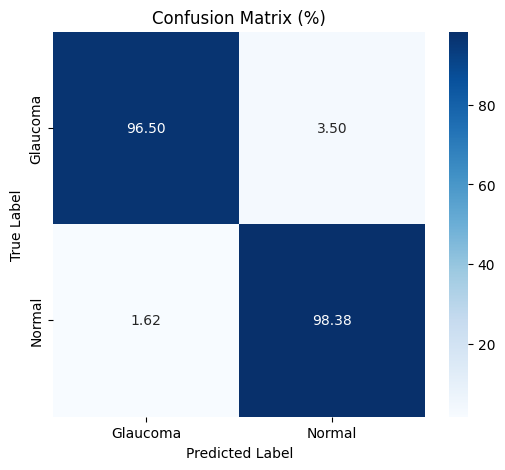

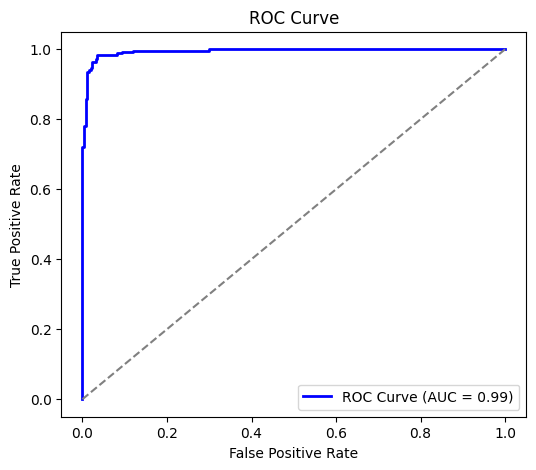

In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# 🔹 **Function to Evaluate Model & Compute Metrics**
def evaluate_model(model, test_loader):
    model.eval()  # Set to evaluation mode
    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Prob for class 1 (Normal)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(probabilities.cpu().numpy())

    return np.array(y_true), np.array(y_pred), np.array(y_scores)

# 🔹 **Plot Confusion Matrix (Percentage)**
def plot_conf_matrix(y_true, y_pred, class_labels):
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentage

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (%)")
    plt.show()

# 🔹 **Plot ROC Curve**
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

# 🔹 **Run Evaluation**
class_labels = ["Glaucoma", "Normal"]  # Ensure correct order

y_true, y_pred, y_scores = evaluate_model(model, test_loader)

# Print classification report
print("✅ Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

# Plot confusion matrix in percentage
plot_conf_matrix(y_true, y_pred, class_labels)

# Plot ROC Curve
plot_roc_curve(y_true, y_scores)
